# CourierIQ ETA Model Training

This notebook walks through:
- Data loading / generation
- Feature exploration & visualisation
- Model training (Random Forest + placeholders for other models)
- Evaluation and saving

In [3]:
# %% Import libraries
import sys
from pathlib import Path

# Add src to path (assumes a typical project layout)
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Custom ETA module (replace with your own implementation)
try:
    from src.models.eta_model import ETAPredictor, generate_synthetic_training_data
except Exception as e:
    print("Could not import custom ETA model – using placeholders instead.")
    # Dummy functions for the sake of the notebook
    def generate_synthetic_training_data(n_samples=5000):
        rng = np.random.default_rng(42)
        timestamps = pd.date_range("2023-01-01", periods=n_samples, freq="15min")
        traffic_level = rng.integers(1, 10, size=n_samples)
        eta_seconds = rng.normal(loc=1800, scale=300, size=n_samples) + traffic_level*50
        return pd.DataFrame({"timestamp": timestamps,
                            "traffic_level": traffic_level,
                            "eta_seconds": eta_seconds})

# Set visual style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load or Generate Data

If you have a real dataset you can load it here; otherwise we generate synthetic data.

In [4]:
# Option 1: Load real data (uncomment if available)
# data = pd.read_csv('../src/data/processed/delivery_data.csv')

# Option 2: Generate synthetic data for testing
print("Generating synthetic training data...")
data = generate_synthetic_training_data(n_samples=5000)

print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {data.columns.tolist()}")
print("\nFirst few rows:")
display(data.head())

Generating synthetic training data...
Dataset shape: (5000, 9)

Columns: ['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon', 'timestamp', 'num_stops', 'traffic_level', 'preparation_time', 'eta_seconds']

First few rows:


,origin_lat,origin_lon,dest_lat,dest_lon,timestamp,num_stops,traffic_level,preparation_time,eta_seconds
0,40.374540,-74.106364,40.373641,-74.000330,2024-01-01 00:00:00,6,0.465074,1272.954806,3542.073863
1,40.950714,-74.026564,40.332912,-73.753253,2024-01-01 01:00:00,2,0.801636,989.564260,15735.472743
2,40.731994,-73.645453,40.176154,-73.937333,2024-01-01 02:00:00,4,0.502344,1155.654983,12914.856474
3,40.598658,-74.159996,40.607267,-74.416697,2024-01-01 03:00:00,7,0.228029,1185.864155,5081.579753
4,40.156019,-73.630350,40.476624,-74.314420,2024-01-01 04:00:00,6,0.212155,1536.226030,11711.228601


## 2. Data Exploration

A quick look at summary statistics and missing values.

In [5]:
print("\n=== Data Summary ===")
display(data.describe())

print("\n=== Missing Values ===")
display(data.isnull().sum())


=== Data Summary ===


,origin_lat,origin_lon,dest_lat,dest_lon,timestamp,num_stops,traffic_level,preparation_time,eta_seconds
count,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000.000000,5000.000000,5000.000000,5000.000000
mean,40.496832,-74.008513,40.501375,-73.992315,2024-04-14 03:30:00,5.044800,0.555109,1044.715109,10690.083799
min,40.000012,-74.499947,40.000158,-74.499748,2024-01-01 00:00:00,1.000000,0.200014,300.153559,1079.445974
25%,40.243863,-74.252854,40.247167,-74.237271,2024-02-22 01:45:00,3.000000,0.383400,672.283727,7163.370419
50%,40.500009,-74.014028,40.496197,-73.987550,2024-04-14 03:30:00,5.000000,0.560182,1051.050979,10334.072291
75%,40.748101,-73.766628,40.760619,-73.748894,2024-06-05 05:15:00,7.000000,0.728468,1419.595868,13724.709364
max,40.999718,-73.500495,40.999805,-73.500075,2024-07-27 07:00:00,9.000000,0.899982,1799.718582,27165.064687
std,0.289634,0.285617,0.290770,0.287806,NaN,2.562051,0.201563,433.541595,4540.799131



=== Missing Values ===


origin_lat          0
origin_lon          0
dest_lat            0
dest_lon            0
timestamp           0
num_stops           0
traffic_level       0
preparation_time    0
eta_seconds         0
dtype: int64

## 3. Visualisations

We’ll plot the relationship between ETA and traffic level, and look at how ETA varies by hour of day and day of week.

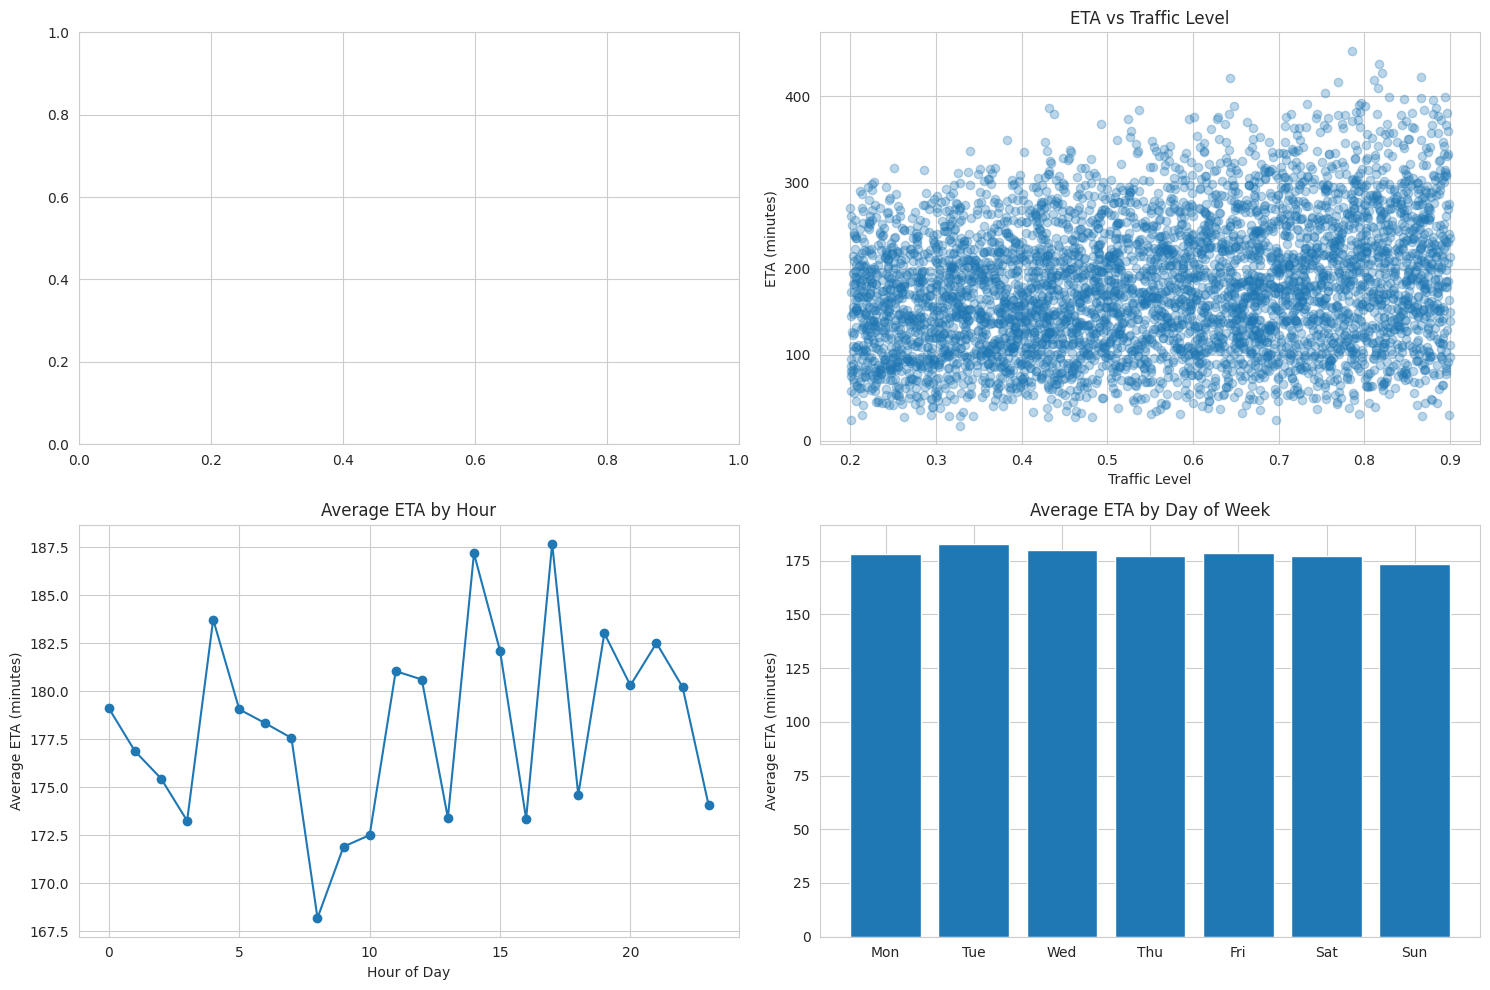

In [6]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ETA vs Traffic Level
axes[0, 1].scatter(data['traffic_level'], data['eta_seconds'] / 60, alpha=0.3)
axes[0, 1].set_xlabel('Traffic Level')
axes[0, 1].set_ylabel('ETA (minutes)')
axes[0, 1].set_title('ETA vs Traffic Level')

# ETA by Hour of Day
hourly_eta = data.groupby(data['timestamp'].dt.hour)['eta_seconds'].mean() / 60
axes[1, 0].plot(hourly_eta.index, hourly_eta.values, marker='o')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average ETA (minutes)')
axes[1, 0].set_title('Average ETA by Hour')
axes[1, 0].grid(True)

# ETA by Day of Week
daily_eta = data.groupby(data['timestamp'].dt.dayofweek)['eta_seconds'].mean() / 60
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), daily_eta.values)
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(days)
axes[1, 1].set_ylabel('Average ETA (minutes)')
axes[1, 1].set_title('Average ETA by Day of Week')

plt.tight_layout()
plt.show()

## 4. Train Models

We’ll start with a Random Forest regressor and leave placeholders for other algorithms you might want to try (e.g., XGBoost, Linear Regression).

In [7]:
# %% Train Random Forest
print("\n" + "="*60)
print("Training Random Forest Model")
print("="*60)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Features & target
X = data[['traffic_level']]
y = data['eta_seconds']

# Train‑test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid (you can expand this as needed)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

# Grid search
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluation on test set
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f} seconds")
print(f"R²: {r2:.4f}")



Training Random Forest Model
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 3731.54 seconds
R²: 0.0004


**Next steps**:
- Add more features (timestamp, weather, etc.) and try feature engineering.
- Try other models (XGBoost, LightGBM, linear regression, neural nets).
- Perform cross‑validation and hyperparameter tuning on the full dataset.
- Save the best model with `joblib` or `pickle` for later deployment.

In [8]:
# %% Optional: save model
import joblib

model_path = "./best_random_forest_eta.pkl"
joblib.dump(best_rf, model_path)
print(f"Model saved to {model_path}")

Model saved to ./best_random_forest_eta.pkl
